In [1]:
!pip install gdown

# Importing Libraries

In [2]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from datasets import Dataset
from transformers import BertModel, BertTokenizer
from transformers import get_scheduler, Trainer, TrainingArguments

# Importing Data

In [3]:
gdown.download("https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy", '/kaggle/working/data.csv', quiet=False)
print('/kaggle/working/data.csv')

Downloading...
From: https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy
To: /kaggle/working/data.csv
100%|██████████| 736k/736k [00:00<00:00, 118MB/s]

/kaggle/working/data.csv


In [4]:
df = pd.read_csv("/kaggle/working/data.csv")
df.head()

,text,comp,en1,en2
0,لابتوب اسوس افضل من لابتوبات ابل ؟ احس مستحيل ...,1,اسوس,ابل
1,اسوس افضل من وجهة نظري,1,اسوس,NaN
2,كلهم نفس المواصفات مافي فرق اسوس افضل من hp في...,1,اسوس,hp
3,التخصصات الهندسية بالذات الحاسب والبرمجيات ماي...,1,اسوس,NaN
4,اسوس افضل من ناحية التنوع والاسعار والعروض,1,اسوس,NaN


# Data Preprocessing

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["comp"], random_state=42)

In [6]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [7]:
model_name = "aubmindlab/bert-base-arabertv02-twitter"

tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

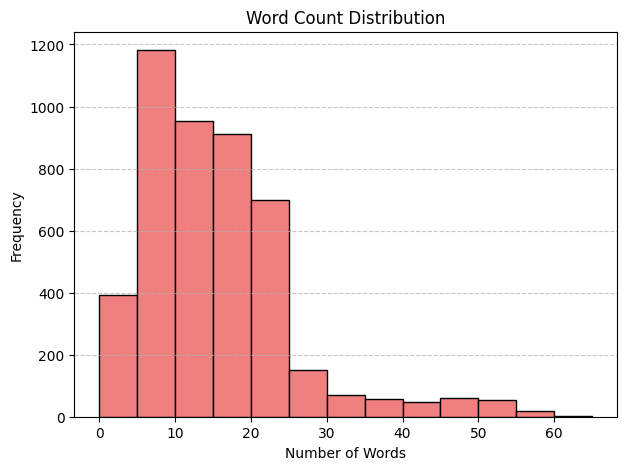

In [8]:
# Calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

bins = range(0, df['word_count'].max() + 5, 5)

plt.figure(figsize=(7,5))
plt.hist(df['word_count'], bins=bins, color='lightcoral', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

df = df.drop(columns=['word_count'])

In [9]:
max_len = 30

In [10]:
# Tokenization function
def tokenize_data(example):
    text = example["text"]
    # Tokenizing the text with padding, truncation, and max_length
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_len)
    
    # Use the 'comp' column as the label
    label = example["comp"]
    
    # Add the label to the tokenized output
    tokens["label"] = label
    
    return tokens

In [11]:
train_dataset = train_dataset.map(tokenize_data, batched=False)
test_dataset = test_dataset.map(tokenize_data, batched=False)

Map:   0%|          | 0/3679 [00:00<?, ? examples/s]

Map:   0%|          | 0/920 [00:00<?, ? examples/s]

In [12]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# AraBERT + LSTM

In [14]:
class BertLSTMClassifier(nn.Module):
    def __init__(self, model_name, num_labels, hidden_size=768, lstm_hidden_size=128, num_lstm_layers=1):
        super(BertLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=0.8,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_labels) # if bi, so * 2
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        lstm_output, _ = self.lstm(hidden_states)  # Shape: (batch_size, seq_len, lstm_hidden_size * 2)
        pooled_output = lstm_output[:, 0, :]  # Take the hidden state of [CLS] token
        
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        logits = self.classifier(pooled_output)  # Classifier output
        
        return logits

In [15]:
model = BertLSTMClassifier(model_name=model_name, num_labels=2)

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
for param in model.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [18]:
epochs = 10

In [19]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.8)
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

In [20]:
patience = 5
best_val_f1 = 0 
epochs_without_improvement = 0 

In [21]:

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
train_f1_scores = []
learning_rates = []
test_losses = []
test_accuracies = []
test_f1_scores = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # Training Phase
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step() 
        
        # Store learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Accumulate training loss
        train_loss += loss.item()
        
        # Store predictions and labels for metrics
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().tolist())
    
    # Calculate training metrics
    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average="macro")
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Evaluation Phase (Validation/Test)
    model.eval()
    test_loss = 0
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Move data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            # Accumulate test loss
            test_loss += loss.item()
            
            # Store predictions and labels for metrics
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            test_preds.extend(preds)
            test_labels.extend(labels.cpu().tolist())
    
    # Calculate test metrics
    test_loss /= len(test_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
    print()

    # Early stopping logic: Check if validation F1 improved
    if test_f1 > best_val_f1:
        best_val_f1 = test_f1
        epochs_without_improvement = 0  # Reset counter if there's improvement
        # Save the model if it performs better
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    # If no improvement for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Stopping training after {epoch + 1} epochs.")
        break

Epoch 1/10
------------------------------
Train Loss: 0.3454, Train Accuracy: 0.8744, Train F1 Score: 0.8743
Test Loss: 0.1010, Test Accuracy: 0.9728, Test F1 Score: 0.9728

Epoch 2/10
------------------------------
Train Loss: 0.1137, Train Accuracy: 0.9666, Train F1 Score: 0.9666
Test Loss: 0.0768, Test Accuracy: 0.9772, Test F1 Score: 0.9772

Epoch 3/10
------------------------------
Train Loss: 0.0879, Train Accuracy: 0.9717, Train F1 Score: 0.9717
Test Loss: 0.0662, Test Accuracy: 0.9815, Test F1 Score: 0.9815

Epoch 4/10
------------------------------
Train Loss: 0.0726, Train Accuracy: 0.9755, Train F1 Score: 0.9755
Test Loss: 0.0629, Test Accuracy: 0.9793, Test F1 Score: 0.9793

Epoch 5/10
------------------------------
Train Loss: 0.0586, Train Accuracy: 0.9815, Train F1 Score: 0.9815
Test Loss: 0.0594, Test Accuracy: 0.9815, Test F1 Score: 0.9815

Epoch 6/10
------------------------------
Train Loss: 0.0524, Train Accuracy: 0.9826, Train F1 Score: 0.9826
Test Loss: 0.0575, Te

# Evaluation

In [22]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

# Variables to store predictions and labels
all_preds = []
all_labels = []

# Evaluation phase
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()  # Get predicted labels
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().tolist())

# Compute metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average="macro")
test_recall = recall_score(all_labels, all_preds, average="macro")
test_f1 = f1_score(all_labels, all_preds, average="macro")

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

/tmp/ipykernel_30/4152432427.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.9815
Test Precision: 0.9817
Test Recall: 0.9817
Test F1 Score: 0.9815


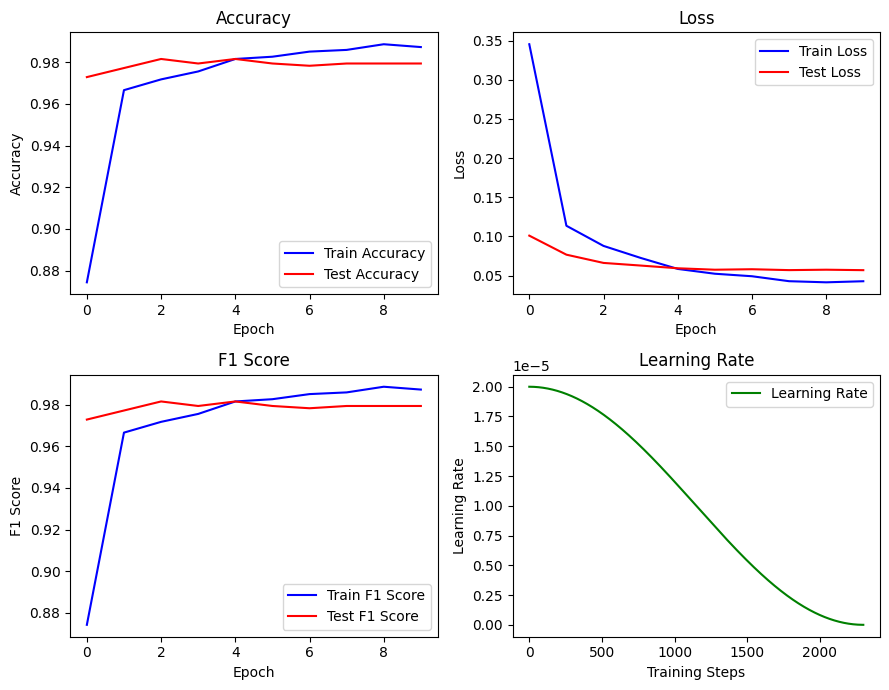

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7))

# Plot Accuracy
axes[0, 0].plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
axes[0, 0].plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy', color='red')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
axes[0, 1].plot(range(len(test_losses)), test_losses, label='Test Loss', color='red')
axes[0, 1].set_title('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot F1 Score
axes[1, 0].plot(range(len(train_f1_scores)), train_f1_scores, label='Train F1 Score', color='blue')
axes[1, 0].plot(range(len(test_f1_scores)), test_f1_scores, label='Test F1 Score', color='red')
axes[1, 0].set_title('F1 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()

# Plot Learning Rate
axes[1, 1].plot(range(len(learning_rates)), learning_rates, label='Learning Rate', color='green')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_xlabel('Training Steps')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

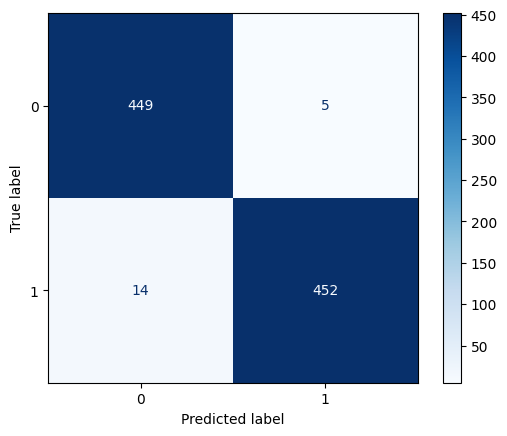

In [24]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()